In [110]:
import os
os.chdir('/Users/alexrotondo/nlp/')

In [111]:
from stopwords import get_stopwords
from embeddings.utils.preprocessing.string_preprocessing import lower_text, remove_punctuation, tokenize_document
from embeddings.utils.document_config import DocumentConfig
from embeddings.utils.preprocessing.token_preprocessing import remove_stopwords, remove_unknown_words
from embeddings.utils.vocab_config import CorpusVocabConfig
from embeddings.utils.vocab import CorpusVocab
from embeddings.skip_gram.model import SkipGramModel

import numpy as np
import pandas as pd
import torch

import seaborn as sb
import matplotlib.pyplot as plt
sb.set_style('darkgrid')

In [112]:
million_songs = pd.read_csv('embeddings/data/spotify_millsongdata.csv')
million_songs.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [113]:
TOTAL_DOCUMENTS = million_songs.shape[0]

In [114]:
def remove_newline(text):
    return text.replace("\n", "")

million_songs.text = million_songs.text.apply(remove_newline)
million_songs.text = million_songs.text.apply(lower_text)
million_songs.text = million_songs.text.apply(remove_punctuation)
million_songs.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,look at her face its a wonderful face and it ...
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,take it easy with me please touch me gently l...
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,ill never know why i had to go why i had to p...
3,ABBA,Bang,/a/abba/bang_20598415.html,making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,making somebody happy is a question of give an...


In [115]:
def remove_newline(text):
    return text.replace("\n", "")

million_songs.text = million_songs.text.apply(remove_newline)
million_songs.text = million_songs.text.apply(lower_text)
million_songs.text = million_songs.text.apply(remove_punctuation)
million_songs.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,look at her face its a wonderful face and it ...
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,take it easy with me please touch me gently l...
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,ill never know why i had to go why i had to p...
3,ABBA,Bang,/a/abba/bang_20598415.html,making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,making somebody happy is a question of give an...


In [116]:
million_songs['tokens'] = million_songs.text.apply(tokenize_document)
million_songs['n_tokens'] = million_songs.tokens.apply(len)

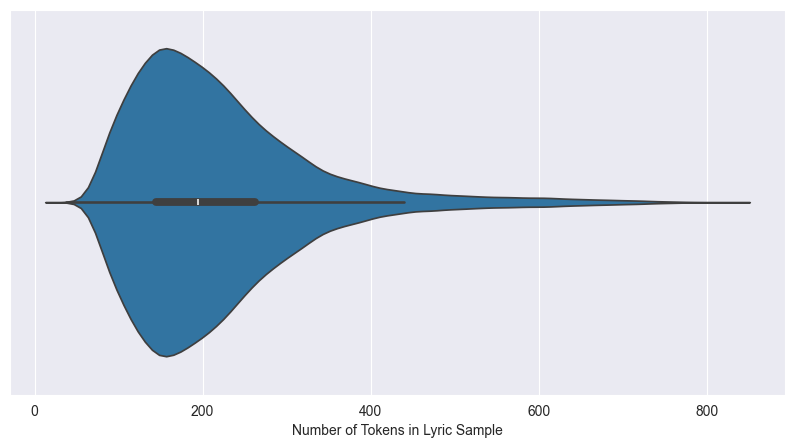

In [117]:
plt.figure(figsize=(10, 5))
sb.violinplot(data=million_songs, x='n_tokens')
plt.xlabel("Number of Tokens in Lyric Sample")
plt.show()

In [118]:
MAX_VOCAB_WORDS = 4000
MAX_NUMBER_OF_TOKENS_PER_DOCUMENT = 256

vocab_config = CorpusVocabConfig(
    max_tokens=MAX_VOCAB_WORDS,
    randomize_token_index=False
)

document_config = DocumentConfig.create(
    lower_text=False, #already done
    exclude_punctuation=False, #already done
    remove_stopwords=True,
    excluded_punctuation=None,
    stopwords=None,
)

song_lyrics: list[str] = million_songs.text.to_list()

vocab: CorpusVocab = CorpusVocab.create(
    documents=song_lyrics,
    document_config=document_config,
    corpus_vocab_config=vocab_config
)

In [119]:
assert vocab.vocab_size == MAX_VOCAB_WORDS + 1

### Get Document Tokens

In [130]:
song_lyric_tokens: list[list[str]] = million_songs.tokens.to_list()

### Remove Stopwords

In [131]:
STOPWORDS = get_stopwords()

def _remove_stopwords(x, stopwords=STOPWORDS):
    return remove_stopwords(document_tokens=x, stopwords=stopwords)

song_lyric_tokens: list = list(map(_remove_stopwords, song_lyric_tokens))

### Remove Unknown Words

In [133]:
def _remove_unknown_words(tokens: list[str], _vocab: CorpusVocab = vocab) -> list[str]:
    return remove_unknown_words(document_tokens=tokens,
                                vocab=_vocab.vocab,
                                unknown_word_identifier=_vocab.unknown_word_identifier)
song_lyric_tokens: list = list(map(_remove_unknown_words, song_lyric_tokens))

### Take only <em>n=256</em> tokens from each token sequence

In [134]:
song_lyric_tokens = [s[:MAX_NUMBER_OF_TOKENS_PER_DOCUMENT] for s in song_lyric_tokens]

### Map Tokens in Document to Identifiers

In [135]:
# create initial encodings
bow_embeddings = []

for i, token_list in enumerate(song_lyric_tokens):
    encoding = [0] * len(token_list)
    for j, token in enumerate(token_list):
        encoding[j] = vocab.get_token_index(token=token)
    bow_embeddings.append(encoding)

In [136]:
set(song_lyric_tokens[0]) & set(get_stopwords())

set()

In [137]:
song_lyric_tokens[0]

['look',
 'face',
 'wonderful',
 'face',
 'means',
 'something',
 'special',
 'look',
 'way',
 'smiles',
 'sees',
 'lucky',
 'can',
 'one',
 '<unknown_word>',
 'shes',
 'just',
 'kind',
 'girl',
 'makes',
 'feel',
 'fine',
 'ever',
 'believe',
 'mine',
 'shes',
 'just',
 'kind',
 'girl',
 'without',
 'im',
 'blue',
 'ever',
 'leaves',
 'go',
 'walk',
 'park',
 'holds',
 '<unknown_word>',
 'hand',
 'well',
 'go',
 'walking',
 'hours',
 'talking',
 'things',
 'plan',
 'shes',
 'just',
 'kind',
 'girl',
 'makes',
 'feel',
 'fine',
 'ever',
 'believe',
 'mine',
 'shes',
 'just',
 'kind',
 'girl',
 'without',
 'im',
 'blue',
 'ever',
 'leaves']

In [138]:
print(np.array(bow_embeddings[0]))

[  80  180  823  180  962  133  964   80   36 2474 2109  574   11   19
    0   61   12  390   37  288   41  306   79   73  143   61   12  390
   37  158    2  125   79 1346   16  152 1876 2278    0  210   55   16
  405 1203  378  131 1531   61   12  390   37  288   41  306   79   73
  143   61   12  390   37  158    2  125   79 1346]


In [140]:
vocab.get_token_index(token='face')

180

### Create Inputs: Context Window & Target Words

In [145]:
million_songs.shape[0] // 96

600

In [169]:
CONTEXT_WINDOW = 4
VOCAB_SIZE = vocab.vocab_size

BATCH_SIZE = 96

In [170]:
from torch.utils.data import Dataset, DataLoader

X, y = [], []

for document_index in range(len(bow_embeddings)):
    document_tokens = bow_embeddings[document_index]

    if len(document_tokens) < CONTEXT_WINDOW * 2 + 1:
        # skip any documents that aren't the minimum required length
        continue

    for index in range(len(document_tokens) - CONTEXT_WINDOW * 2):
        _token_sequence = document_tokens[index: index + (CONTEXT_WINDOW * 2) + 1]

        _input = _token_sequence.pop(CONTEXT_WINDOW)
        _context_window = _token_sequence

        for _target in _context_window:

            X.append(_input)
            y.append(_target)

X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)

class MillionSongDataSet(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

dataset = MillionSongDataSet(data=X, labels=y)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [171]:
X.size()

torch.Size([50720472])

batch_X = []
batch_y = []

for batch_index in range(BATCH_SIZE):
    print(f"preparing data for batch #{batch_index + 1}")

    starting_document_index = batch_index * BATCH_SIZE
    ending_document_index = starting_document_index + BATCH_SIZE

    print(f"preparing data for document indices #{starting_document_index} – #{ending_document_index}")
    X, y = [], []

    for document_index in range(starting_document_index, ending_document_index + 1):
        document_tokens = bow_embeddings[document_index]

        if len(document_tokens) < CONTEXT_WINDOW * 2 + 1:
            # skip any documents that aren't the minimum required length
            continue

        for index in range(len(document_tokens) - CONTEXT_WINDOW * 2):
            _token_sequence = document_tokens[index: index + (CONTEXT_WINDOW * 2) + 1]

            _input = _token_sequence.pop(CONTEXT_WINDOW)
            _context_window = _token_sequence

            for _target in _context_window:

                X.append(_input)
                y.append(_target)

    X = torch.tensor(X, dtype=torch.long)
    y = torch.tensor(y, dtype=torch.long)

    batch_X.append(X)
    batch_y.append(y)

### Import & Train Model

In [172]:
NUM_EPOCHS = 20

In [173]:
model = SkipGramModel(
    vocab_size=vocab.vocab_size
)

In [174]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

# define loss function
loss_function = nn.CrossEntropyLoss()

# define optimizer
# -> include model parameters
# -> include base learning rate
optimizer = optim.Adam
optimizer = optimizer(model.parameters(), lr=0.025)

# define learning rate scheduler & function
# this function will linearly decrease the base learning rate to zero
# over the total number of epochs
lr_lambda = lambda _epoch: (NUM_EPOCHS - _epoch) / NUM_EPOCHS
lr_scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

In [175]:
loss_by_epoch = []

In [176]:
for epoch in range(NUM_EPOCHS):
    print(f"starting epoch #{epoch + 1}")
    running_loss = []

    for batch_data, batch_labels in dataloader:

        optimizer.zero_grad()
        forward_pass_results = model(batch_data)
        loss = loss_function(forward_pass_results, batch_labels)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())

    lr_scheduler.step()

    print(f"mean loss for epoch {epoch}: {np.mean(running_loss)}")
    loss_by_epoch.append(running_loss)

   # model_path = f"embeddings/skip_gram/model/model_at_epoch_{epoch + 1}.pt"
   # torch.save(model, model_path)

starting epoch #1


KeyboardInterrupt: 

In [154]:
torch.save(model, 'embeddings/skip_gram/model/skip_gram.pt')

In [155]:
mean_loss_by_epoch = list(map(np.mean, loss_by_epoch))
mean_loss_by_epoch

[6.364006923304664,
 6.261812938584222,
 6.1929247577985125,
 6.125681042671204,
 6.047164254718357]